In [37]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    accelerator = "gpu"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    accelerator = "mps"
else:
    device = torch.device("cpu")


from main_code.dataset import FashionDataset
from main_code.nn_definition import FashionAutoEncoder
from main_code.evaluation import evaluate_model
from main_code.visualization import visualizer, visualize_dataset

from utils.save_load_model import save_model, load_model

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
batch_size = 1

In [39]:
#Training Dataset and Dataloader
train_data = FashionDataset('dataset/woman_25_34_caucasian_frontal_standing/trainset.txt')
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
print(len(train_data))
print(train_data.image_names)

1
['000001']


In [40]:
num_batches = len(train_dataloader)
num_batches

1

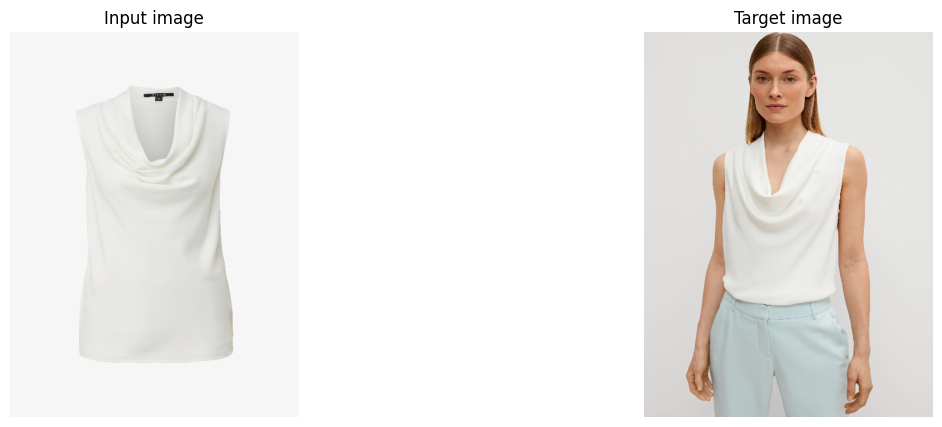

In [41]:
visualize_dataset(train_data, num_imgs = 1)

In [62]:
#Model Initialization
hparams = {
    'batch_size': batch_size,
    'num_batches': num_batches,
    'num_resnet_trainable':0,
    'optimizer': 'Adam',
    'learning_rate': 0.01,
    'momentum': 0.0
}
model = FashionAutoEncoder(hparams = hparams)

In [63]:
inputs, targets = next(iter(train_dataloader))
inputs.shape, targets.shape

(torch.Size([1, 3, 680, 510]), torch.Size([1, 3, 680, 510]))

In [64]:
#Initialize Tensorboard Logger
logger = pl.loggers.TensorBoardLogger(save_dir='lightning_logs', name="logs")

In [65]:
#Initialize Model Trainer 
trainer = pl.Trainer(
    max_epochs=200,
    logger=logger,
    log_every_n_steps=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience = 10, mode='min')],
    accelerator=accelerator,
    devices= 1 if accelerator == "mps" else None,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [66]:
#Train Model
trainer.fit(model, train_dataloaders = train_dataloader, val_dataloaders = train_dataloader)


  | Name             | Type       | Params
------------------------------------------------
0 | loss             | MSELoss    | 0     
1 | resnet_trainable | Identity   | 0     
2 | resnet_frozen    | Sequential | 2.8 M 
3 | decoder          | Sequential | 115 K 
------------------------------------------------
115 K     Trainable params
2.8 M     Non-trainable params
2.9 M     Total params
11.591    Total estimated model params size (MB)


Epoch 154: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=2]          


In [67]:
save_model(model, 'model')

'models/model'

In [69]:
evaluate_model(model, train_dataloader) #latest best for max num train images: 99.07% for 120 images

{'accuracy': 0.0}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


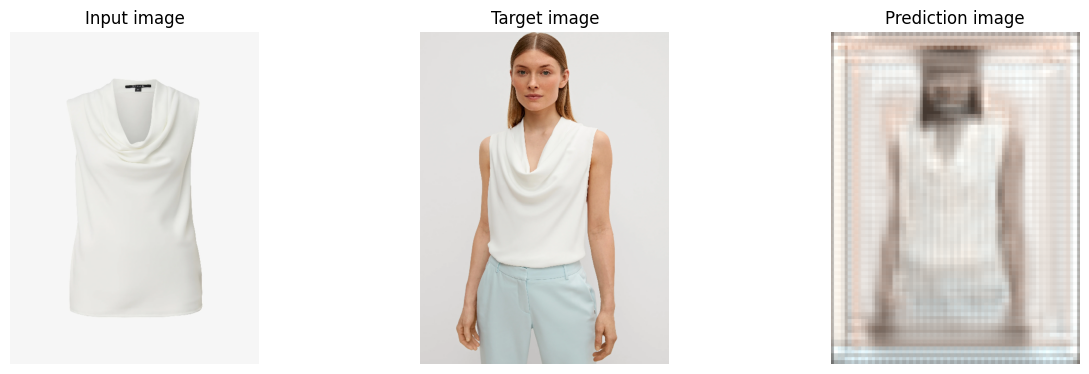

In [70]:
visualizer(model, train_data, num_imgs = 5)

In [ ]:
evaluate_model(model, validation_dataloader) #latest best for max num train images: 64.76% for 16 val images, 120 train images

In [ ]:
visualizer(model, validation_data, num_imgs = 10)

In [3]:
model_loaded = load_model(SkinSegmentationNN, file_name='model')

In [4]:
#Validation Dataset and Dataloader
validation_data = SkinSegmentationData('dataset/validate.txt')
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=15, shuffle=False)
len(validation_data)

In [5]:
evaluate_model(model_loaded, validation_dataloader) #latest best: 68.8% for 15 val images

{'accuracy': 0.6882957637652434,
 'non-skin num instances': 18936,
 'non-skin recall': 0.8259400084495142,
 'non-skin precision': 0.7656533020022519,
 'non-skin f1 score': 0.7946548789472346,
 'skin num instances': 28074,
 'skin recall': 0.5830305620859157,
 'skin precision': 0.7341885709159415,
 'skin f1 score': 0.6499364675984752,
 'acne num instances': 12500,
 'acne recall': 0.71752,
 'acne precision': 0.5334562540890977,
 'acne f1 score': 0.6119469177498037}